In [31]:
import re
import random
import pandas as pd
import hashlib

In [32]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
mean = cards_to_age["age"].mean()
if random.random() < (mean/160):
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications
priority_headers = [
    "Django", 
    "Python + Oauth2.0"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.075
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

In [33]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Ubuntu,257.527564,9.904906,52.497276,26
eDiscovery,546.801345,10.125951,75.164674,54
Network Terms,198.235976,13.215732,32.493138,15
GUI Docker Container,321.488332,15.308968,47.120814,21
SSH + SCP,483.991598,16.689365,92.817616,29
Exchange Online and Defender,759.548120,19.475593,67.485519,39
"The Mines of the Behemoth, Shea",1068.847262,21.813209,115.591044,49
"Everything is Tuberculosis, Green",611.952145,26.606615,187.808336,23
Linux,1154.501011,36.078157,237.154051,32
Docker,1169.128664,37.713828,168.331766,31


# Histogram

sum of ages: ~37771.41


<Axes: >

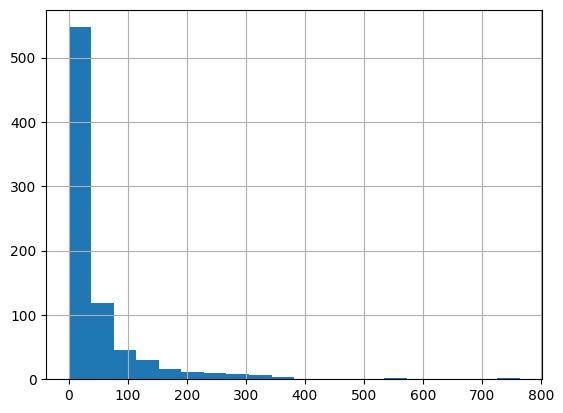

In [34]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~37771.41


<Axes: >

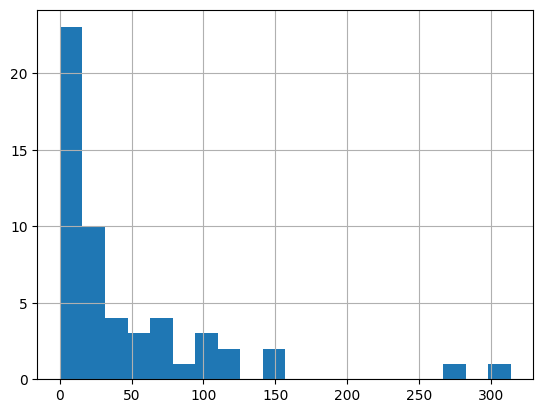

In [35]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python']['age'].hist(bins=20)

# Completely Random Shuffle

In [36]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [37]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [38]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [39]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [40]:
# n = random.choice([2, 3, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [41]:
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

choices = ['floor', 'mod']
option = random.choice(choices)
if option == 'floor':
    n=5
    existing_cards['n_fold'] = existing_cards['count'] // n
    print("floor dividing for n-fold")
elif option == 'mod':
    n=3
    existing_cards['n_fold'] = existing_cards['count'] % n
    print("modulo for n-fold")
else: raise NotImplementedError


if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

floor dividing for n-fold
Cards found: 801
Total card age: 37771.41


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
44,Accounting,Reconciliation\nComparing records from two sou...,81a1a67b91258e37f9d7563aaded7aab,323.747340,98.070990,-323.747340,490.354948,0.638962,5,0,0,-323.747340
46,Accounting,Contra-Asset Account\nAn account that offsets ...,e4e93a8a437c23e63933092562ca3175,129.062024,98.070990,-323.747340,490.354948,0.638962,5,1,0,-129.062024
45,Accounting,Journal Entry\nThe basic transaction record sh...,7586d6eb6a4a94b1b707b4b735136a4b,26.856197,98.070990,-323.747340,490.354948,0.638962,5,2,0,-26.856197
131,Accounting,Retained Earnings\nThe cumulative net income o...,1150d1bf321129bc7ed28e668af16c6b,8.541408,98.070990,-323.747340,490.354948,0.638962,5,3,0,-8.541408
132,Accounting,Current Ratio\nLiquidity ratio = Current Asset...,8abb049ede1e9522a30b7f4e1725f490,2.147978,98.070990,-323.747340,490.354948,0.638962,5,4,0,-2.147978
42,TSQL,COALESCE Function:\n\nReturns the first non-nu...,064f4b20231fba72a8b35d1e993d28e8,307.867728,97.086906,-307.867728,776.695249,0.114658,8,0,0,-307.867728
43,TSQL,Indexing Considerations:\n\nEnsure columns use...,45448e98e466ab813ded20e2fa405dff,172.469796,97.086906,-307.867728,776.695249,0.114658,8,1,0,-172.469796
128,TSQL,Table Variables:\n\nDeclared using DECLARE and...,268660150f0a42727427b3701cbd014e,162.890601,97.086906,-307.867728,776.695249,0.114658,8,2,0,-162.890601
129,TSQL,Q: How do window functions differ from aggrega...,8a0c598806647a8b39c057348c65f578,57.337132,97.086906,-307.867728,776.695249,0.114658,8,3,0,-57.337132
41,TSQL,CASE Expressions:\n\nImplements conditional lo...,f017d6e7d5dc77052491955f455502ce,39.947553,97.086906,-307.867728,776.695249,0.114658,8,4,0,-39.947553



## Random

In [42]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [43]:
existing_cards.head(10)['age'].sum()

np.float64(1230.8677573550772)

In [44]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
15,Microsoft Purview,"The technical metadata includes schema, data t...",e075b6e051b56bf4339683cc14994184,764.070584,88.759896,-764.070584,3550.395844,0.412357,40,0,0,-764.070584
50,WinHex,Advanced Adjacent Terms\nZoned Bit Recording (...,6c188d655123f654671ddbe9e25ee8b3,737.617135,62.323539,-737.617135,1308.794323,0.772478,21,0,0,-737.617135
1,Node.js and Vite,Debugger attached\nA message from Node when ru...,128567e0fcdb7e5c074de0dc7ff33928,600.268463,77.417268,-600.268463,2709.604397,0.798596,35,0,0,-600.268463
88,Node.js and Vite,"""Unexpected token"" (Babel error)\nJS syntax er...",9c8d82516fc972a6c5b042007d3943a8,569.977084,77.417268,-600.268463,2709.604397,0.798596,35,1,0,-569.977084
81,Terraform Codebox,corepack enable\nA command that activates Core...,dbbb73cbfd843df20879274cb633c9ac,561.084664,70.645947,-561.084664,2260.670290,0.195011,32,0,0,-561.084664
8,"Mexican Gothic, Moreno-Garcia","trousseau (troo-SOH)\nnoun\nThe clothes, linen...",e68146db262d468ec9bc38f4439717a0,424.907227,56.922872,-424.907227,1309.226048,0.771335,23,0,0,-424.907227
23,Power BI,Q: What is the effect of data type mismatches ...,237db394d61828ffc8fdd92606a5ca49,391.792346,73.354071,-391.792346,660.186635,0.007076,9,0,0,-391.792346
101,Microsoft Purview,The most effective end-user documentation will...,cd14ee472435ecdf15fed24da734eca3,355.861190,88.759896,-764.070584,3550.395844,0.412357,40,1,0,-355.861190
27,Python + Oauth2.0,handler.wfile.write()\n\nWrites a response bac...,0a49706ef2305810297830c1b5b23dc6,348.107907,101.077587,-348.107907,1617.241386,0.296775,16,0,0,-348.107907
168,Terraform Codebox,"In Windows PowerShell, RSA SSH keys can be gen...",51fc9593224fc39fc8e432d6be5db48e,346.679924,70.645947,-561.084664,2260.670290,0.195011,32,1,0,-346.679924


In [45]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 47.155'